# Exploring the Data
Exploration of Quarterly Reports and their likelihood to influence future price movement in the following report.

## Importing Necessary libraries

In [25]:
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 70)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle

### Loading the Data

In [26]:
with open("main_df.pkl",'rb') as fp:
    final_df = pickle.load(fp)

## Visualizing the count of Buy, Hold, and Sells
Visual check for any class imbalance among the quarterly reports.

In [27]:
# Separating each class into respective DataFrames
buy_df = final_df[final_df['Decision']==1].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
hold_df = final_df[final_df['Decision']==2].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
sell_df = final_df[final_df['Decision']==0].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)

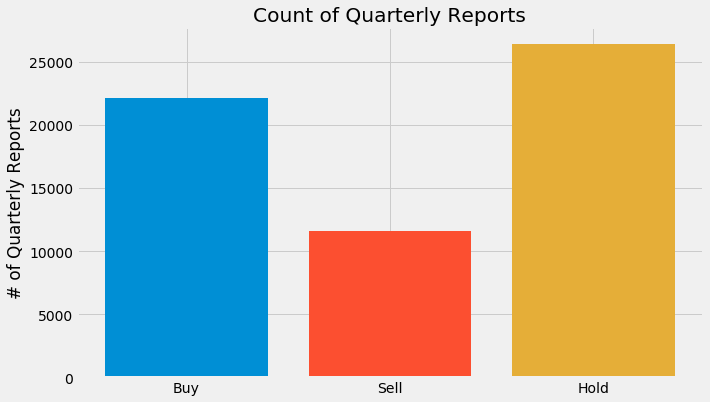

In [28]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# Plotting the count of each DataFrame of each class
plt.bar("Buy", buy_df.shape[0])
plt.bar("Sell", sell_df.shape[0])
plt.bar("Hold", hold_df.shape[0])

plt.ylabel("# of Quarterly Reports")
plt.title('Count of Quarterly Reports')
plt.show()

## Correlations
Checking for any correlation between the future quarterly report's price and the current quarter's features.

#### Function for Visualizing and Correlation Matrix

In [29]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

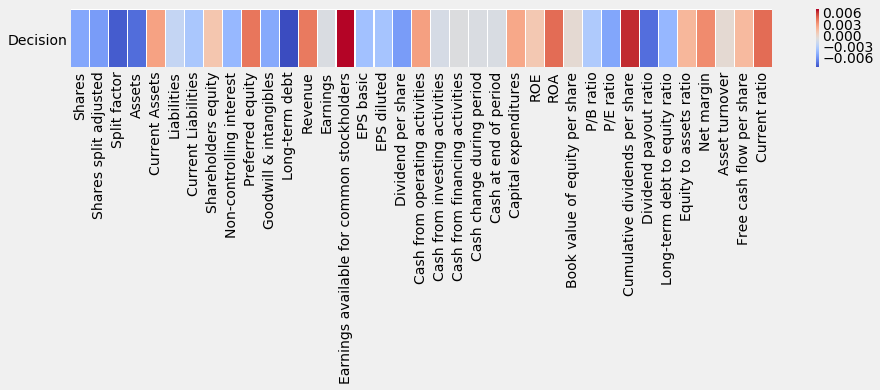

In [30]:
# Correlation DF of all classes
corr = final_df.corr().iloc[[-1],:-1]

# Plotting the Correlation DF as a heatmap
plt.figure(figsize=(14,1))
sns.heatmap(corr, annot=False, linewidths=.1, cmap="coolwarm")
plt.xticks()
plt.yticks(rotation=0)
plt.show()

## Feature Selection
Reducing the feature set for computational simplicity and potential improvement in accuracy.

### Feature Importances from the DF

In [31]:
from sklearn.ensemble import ExtraTreesClassifier

In [36]:
forest = ExtraTreesClassifier(n_estimators=200)

# Setting the corresponding variables for our classifier
X = final_df.drop(['Decision'], 1)
y = final_df.Decision

# Fitting the classifier
%timeit forest.fit(X, y)

39.2 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
# Determining the important features
importances = forest.feature_importances_

# The standard deviation among the trees for the important features
std = np.std([i.feature_importances_ for i in forest.estimators_], axis=0)

# Indexing and sorting the important features
indices = np.argsort(importances)[::-1]

### Plotting the most important features

Feature Rankings:
1. P/B ratio: 0.04177047309640281
2. Assets: 0.031895452686656924
3. Shares split adjusted: 0.030638229247726866
4. Shares: 0.030365985839840955
5. P/E ratio: 0.029952933057890783
6. Liabilities: 0.029692442037536432
7. Asset turnover: 0.029677288764638335
8. Current Assets: 0.02960127018386941
9. Cash at end of period: 0.02957168555570655
10. Revenue: 0.02939006331662369
11. Capital expenditures: 0.02885438519447414
12. Equity to assets ratio: 0.028796516163380727
13. Free cash flow per share: 0.02857351344058244
14. Cash from operating activities: 0.028333686034337
15. Cumulative dividends per share: 0.028327856694602905
16. Current Liabilities: 0.028278815797531866
17. Cash change during period: 0.02819277379481718
18. Shareholders equity: 0.028179157279832955
19. Current ratio: 0.028150309160150915
20. Goodwill & intangibles: 0.028070002374854304


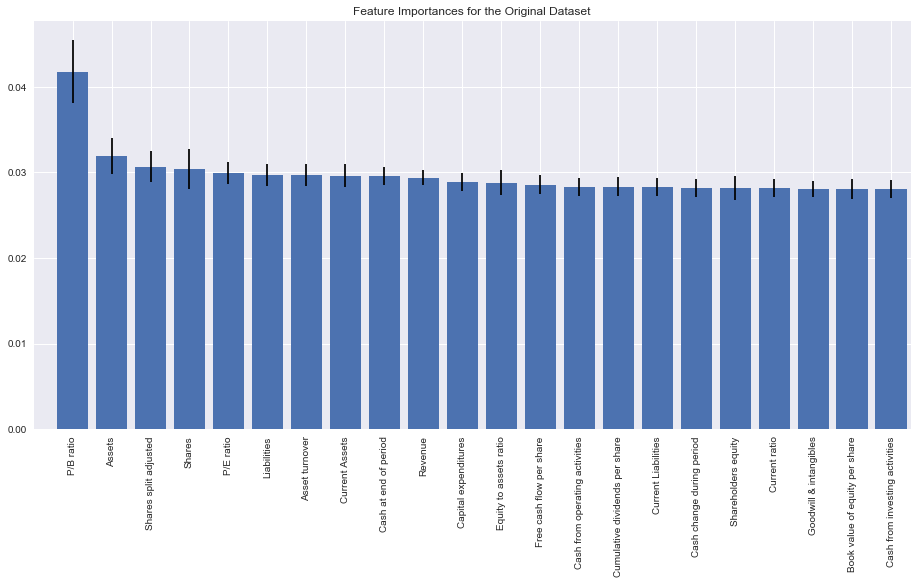

In [38]:
plt.style.use('seaborn')

print("Feature Rankings:")

# Showing the top 20 features
for i in range(20):
    print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]}")
    
# Plotting the top 20 features
plt.figure(figsize=(14,7))

plt.title("Feature Importances for the Original Dataset")
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices], align='center')

plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, 21.5])
plt.show()

#### Selecting the Top 10 most important features
According to the feature importances from the original dataset.

In [39]:
# Assigning the top 10 features as a new DF
top10_df = final_df[X.columns[indices][:10]].join(final_df.Decision)
top10_df.head(5)

,P/B ratio,Assets,Shares split adjusted,Shares,P/E ratio,Liabilities,Asset turnover,Current Assets,Cash at end of period,Revenue,Decision
0,0.000000,3.011116,0.060170,0.060170,0.000000,2.212896,0.00000,1.505420,-28.508772,10.641140,0.0
1,-40.465919,6.911624,0.164196,0.164196,0.000000,9.182531,0.00000,5.675302,-28.118609,7.444668,0.0
2,-31.739130,7.640220,0.739888,0.739888,0.000000,8.034188,0.00000,5.819611,41.678521,26.292135,2.0
3,-2.335456,9.293769,0.088384,0.088384,0.000000,16.044304,0.00000,-3.430592,-56.526104,-15.747331,0.0
4,-28.260870,-1.390096,0.066338,0.066338,-25.917859,-5.535860,-6.47482,-8.478301,86.836028,-16.156283,2.0


### Exporting the Top 10 Dataframe

In [40]:
with open("top10_df.pkl", "wb") as fp:
    pickle.dump(top10_df, fp)